In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import scipy as sp
from scipy import signal
from statsmodels.tsa.stattools import adfuller
from IPython.display import Markdown as md
import copy

# Drinking and Mood Autocorrelation, Stationarity and Cross Correlation.

In [2]:
datafile = "/Users/djpassey/Data/Muri/SHINE_EMA_Round1_19May2020.csv"
ema = pd.read_csv(datafile, parse_dates=True)
# Convert notification time to a datetime object
ema['Notification.Time'] = pd.to_datetime(ema['Notification.Time'])
# 'Num_Alcohol is our new column containing the drinking data we want to measure. In this notebook
# we are interested in 'if' the individual drank or not so we simply set the column equal to "Had_Alcohol"
# rather than summing up the number of drinks of each type the individual reported
ema['Num_Alcohol'] = ema.HadAlcohol

In [3]:
# Constants for determining if a prompt occured in the morning or evening
MORNING = ['FirstMorning', 'Morning'] 
EVENING = ['Evening']
# p-value for this notebook
PVAL = 0.01
# Notebook color scheme
COLORS = ["salmon", "teal", "grey", "green"]

def drink_sessions(df, prompt=None):
    """ Function for removing data from prompts where drinking was not assessed
    
        Parameters
        ----------
        df (pandas Dataframe): ema data
        prompt (string): one of `["morning", "evening", None]`. Specifies if the 
        function should return only data from morning or evening prompts. Defaults 
        to None and therefore returns data from both morning and evening prompts
        
        Returns
        -------
        ds (pandas Dataframe): data frame containing only prompts where drinking was 
        assessed. If `prompt` was not none, the data only contains information from  
        either morning or evening prompts. The dataframe is also sorted by notification time
    """
    if prompt is None:
        ds = df[df["Session.Name"].isin(MORNING+EVENING)]
    if prompt is "morning":
        ds = df[df["Session.Name"].isin(MORNING)]
    if prompt is "evening":
        ds = df[df["Session.Name"].isin(EVENING)]    
    ds.fillna({"Num_Alcohol":0, "HadAlcohol":0})
    ds.sort_values("Notification.Time", inplace=True)
    return ds

def fourier_transform(t, y):
    """ Take the fourier transform of a signal, rescale and provide a frequency axis
        array for easy plotting
        
        Parameters
        ----------
        t (array): Evenly spaced time values
        y (array): Time series, `y[i]` corresponds to the value of the 
        time series at time `t[i]`
    """
    total_time = float(t[-1] - t[0])
    N = len(y)
    xf = np.arange(N)/ (total_time)
    yf = sp.fft.fft(y) / N
    # Take half of the dfft and multiply by 2 because it is a mirror image
    yf = 2*np.abs(yf[:N//2])
    xf = xf[:N//2]
    return xf, yf

def hist_templ(
    *data, 
    xlab="Value", 
    ylab="Frequency", 
    title="Histogram", 
    label=["Morning Prompt", "Evening Prompt"],
    bins=20,
    alpha=0.6
):
    """Histogram template function"""
    for i, x in enumerate(data):
        plt.hist(x, bins=bins, color=COLORS[i], alpha=0.6, label=label[i])
    plt.legend()
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    p = plt.title(title)
    return p

# Extract Mood and Drinking Time Series

We separate by morning and evening prompt so that there are 24 hours between each datapoint. The dictionary `processed_data` contains all of the processed data that we study in this notebook. Here is a summary of the entries in the `processed_data` dictionary. (Some of these entries are added later

1. `processesed_data["id"]` is a 1D array of id numbers. All of the following arrays are kept in order corresponding to id number.

2. `processesed_data["drink.morning"]` is a 2D array where the `i`th row is a drinking time series corresponding to the individual with id number equal to `processesed_data["id"][i]`. Each drinking time series here has 28 entries corresponding to the 28 *morning* prompts.

3. `processesed_data["drink.evening"]` is a 2D array where the `i`th row is a drinking time series corresponding to the individual with id number equal to `processesed_data["id"][i]`. Each drinking time series here has 28 entries corresponding to the 28 *evening* prompts.

4. `processesed_data["mood.morning"]` is a 2D array where the `i`th row is a positive mood time series corresponding to the individual with id number equal to `processesed_data["id"][i]`. Each mood time series here has 28 entries corresponding to the 28 *morning* prompts.

5. `processesed_data["mood.evening"]` is a 2D array where the `i`th row is a positive mood time series corresponding to the individual with id number equal to `processesed_data["id"][i]`. Each mood time series here has 28 entries corresponding to the 28 *morning* prompts.

6. `processed_data["{mood or drink}.{morning or evening}.ft"]` For entries 2-5 above, appending `".ft"` onto the end of the key (e.g. `"mood.evening" -> "mood.evening.ft")` produces a 2D array where each row is the fourier transform of the corresponding row in the original time series array. (e.g. `processesed_data["mood.evening.ft"][2, :]` contains the fourier transform of `processesed_data["mood.evening"][2, :]`)

7. `processed_data["{mood or drink}.{morning or evening}.adfuller"]` For entries 2-5 above, appending `".adfuller"` onto the end of the key (e.g. `"mood.evening" -> "mood.evening.adfuller")` produces a 1D array where the `i`th entry is a p-value corresponding to an Augmented Dickey-Fuller unit root test (a statistical test for stationarity) applied to the `i`th row of the corresponding time series array. (e.g. `processesed_data["mood.evening.ft"][2]` contains the p-value corresponding to a Augmented Dickey-Fuller test run on `processesed_data["mood.evening"][2, :]`)



In [4]:
processed_data = {
    "id" : [],
    "drink.morning" : [],
    "drink.evening" : [],
    "mood.morning" : [],
    "mood.evening" : []
}

time_series_keys = ["drink.morning", "drink.evening", "mood.morning", "mood.evening"]

# Separate morning and evening prompts
morn = drink_sessions(ema, prompt="morning")
eve = drink_sessions(ema, prompt="evening")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
# Participants to exclude
EXCLUDE_ID = [52927]

# Drinking and Mood data tuples
drinkmorn = tuple()
drinkeve = tuple()
moodmorn = tuple()
moodeve = tuple()

for idnum in ema.ID.unique():
    if idnum not in EXCLUDE_ID:
        # add ID numbers
        processed_data["id"].append(idnum)
        # Look at subset of data corresponding to the current ID
        morn_id = morn[morn.ID == idnum]
        eve_id = eve[eve.ID == idnum]
        # Extract morning and evening drinks time series and append it to tuple
        drinkmorn += (morn_id["Num_Alcohol"].fillna(0).values,)
        drinkeve += (eve_id["Num_Alcohol"].fillna(0).values,)
        # Extract morning and eveing positive mood time series
        morn_m = morn_id.PositiveMood
        eve_m = eve_id.PositiveMood
        # Fill nans with the mean and append to tuple
        moodmorn += (morn_m.fillna(np.mean(morn_m)).values,)
        moodeve += (eve_m.fillna(np.mean(eve_m)).values,)
    
# Turn tuple of timeseries into arrays
processed_data["drink.morning"] = np.vstack(drinkmorn)
processed_data["drink.evening"] = np.vstack(drinkeve)
processed_data["mood.morning"] = np.vstack(moodmorn)
processed_data["mood.evening"] = np.vstack(moodeve)

In [6]:
# Take fourier transform of each time series type
for key in time_series_keys:
    Yf = tuple()
    for ts in processed_data[key]:
        x = np.arange(28)
        xf, yf = fourier_transform(x, ts)
        Yf += (yf,)
    processed_data[key + ".ft"] = np.vstack(Yf)

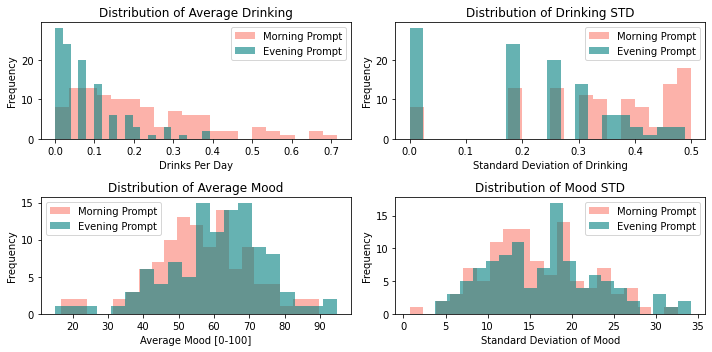

In [7]:
plt.rcParams["figure.figsize"] = [10, 5]

# Drinking Data

plt.subplot(2,2, 1) # Mean drinking
dm_mean = np.mean(processed_data["drink.morning"], axis=1)
de_mean = np.mean(processed_data["drink.evening"], axis=1)
hist_templ(dm_mean, de_mean, xlab="Drinks Per Day", title="Distribution of Average Drinking")

plt.subplot(2,2, 2) # Drinking STD
dm_mean = np.std(processed_data["drink.morning"], axis=1)
de_mean = np.std(processed_data["drink.evening"], axis=1)
hist_templ(dm_mean, de_mean, xlab="Standard Deviation of Drinking", title="Distribution of Drinking STD")

# Mood Data

plt.subplot(2,2, 3) # Mean mood
dm_mean = np.mean(processed_data["mood.morning"], axis=1)
de_mean = np.mean(processed_data["mood.evening"], axis=1)
hist_templ(dm_mean, de_mean, xlab="Average Mood [0-100]", title="Distribution of Average Mood")

plt.subplot(2,2, 4) # Mood std
dm_mean = np.std(processed_data["mood.morning"], axis=1)
de_mean = np.std(processed_data["mood.evening"], axis=1)
hist_templ(dm_mean, de_mean, xlab="Standard Deviation of Mood", title="Distribution of Mood STD")

plt.tight_layout()
plt.show()

## Fourier Transform of Drinking Boxplot

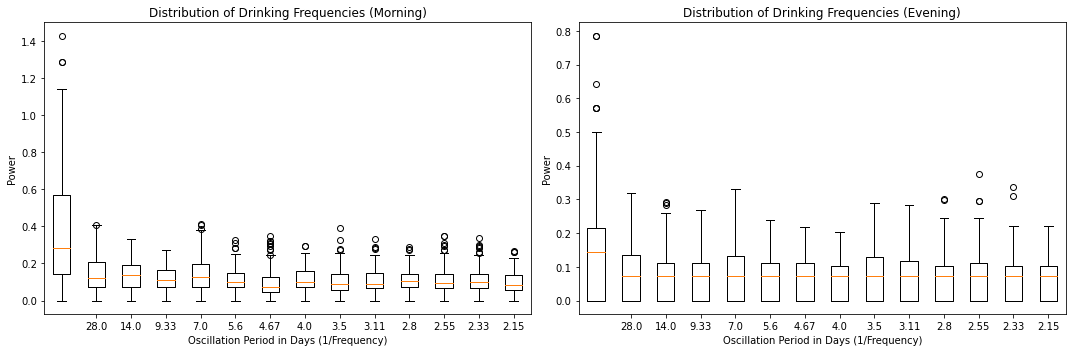

In [8]:
plt.rcParams["figure.figsize"] = [15, 5]

# Frequency axis (For fourier transform)
total_time = 28.0
N = 28
xf = np.arange(N)/ (total_time)
xf = xf[:N//2]

# Drinking Data

plt.subplot(1, 2, 1) # Fourier transform morning
plt.boxplot(processed_data["drink.morning.ft"])
plt.xticks(np.arange(2,15), np.round(1/xf[1:],2))
plt.xlabel("Oscillation Period in Days (1/Frequency)")
plt.title("Distribution of Drinking Frequencies (Morning)")
plt.ylabel("Power")
#plt.ylim(-.1, 2.50)

plt.subplot(1, 2, 2) # Fourier transform evening
plt.boxplot(processed_data["drink.evening.ft"])
plt.xticks(np.arange(2,15), np.round(1/xf[1:],2))
plt.xlabel("Oscillation Period in Days (1/Frequency)")
plt.title("Distribution of Drinking Frequencies (Evening)")
plt.ylabel("Power")
#plt.ylim(-.1, 2.50)
plt.tight_layout()
plt.show()

## Distribution at Each Frequency

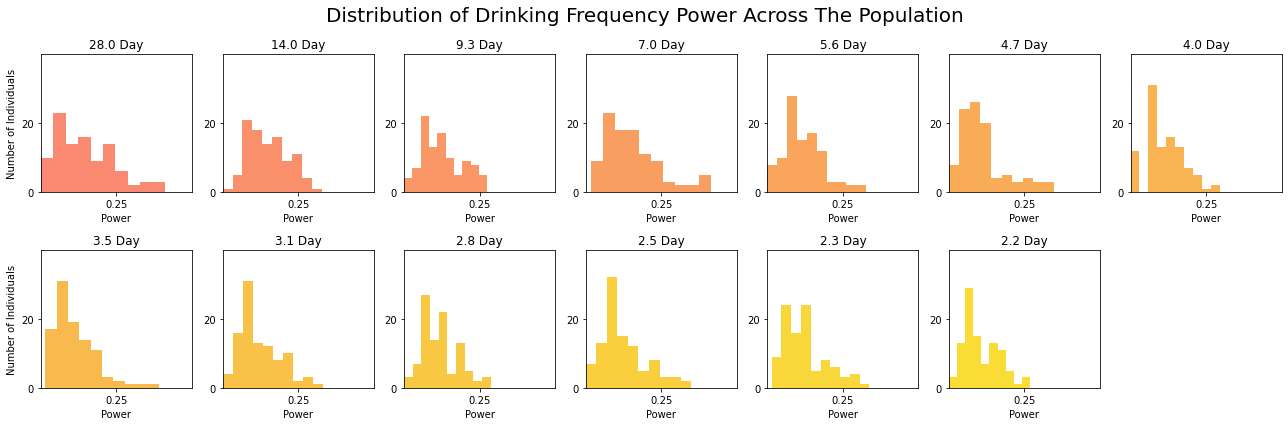

In [9]:
plt.rcParams["figure.figsize"] = [18, 6]

salmon = np.array([250,131,117]) / 256
# Lets do a gradient 
color_grad_step = np.array([0, 7, -5]) / 256
drinker_idx = np.where(np.mean(processed_data["drink.morning"], axis=1) != 0)[0]
drinkers = processed_data["drink.morning.ft"][drinker_idx, :]
cols = drinkers.shape[1]

for j in range(1, cols):
    plt.subplot(2,7,j)
    freq_dist = drinkers[:, j]
    plt.hist(freq_dist, color=salmon + j*color_grad_step)
    plt.xlim(0,.5)
    plt.ylim(0, 40)
    plt.xticks([0.25])
    plt.yticks([0, 20])
    plt.title(f"{round(1/xf[j],1)} Day")
    if j % 7 == 1:
        plt.ylabel("Number of Individuals")
    plt.xlabel("Power")
    
plt.suptitle("Distribution of Drinking Frequency Power Across The Population", fontsize=20)
plt.tight_layout()
plt.show()

Fourier transform analysis of each drinking time series in the population. Frequency information is extracted from individual drinking time series and gives information about the relative importance of different oscillatory periods in the individual's time series. For example, we hypothesize that a seven day cycle should be an important component of a drinking time series, given the prevalence of drinking each weekend. Each plot shows the distribution of the importance of the specified frequency across the population. For example, the upper left plot shows the distribution of the importance of a 28 day cycle across the population and the lower right plot shows the distribution of a 2.2 day cycle across the population. Shorter cycles are plotted in lighter colors.

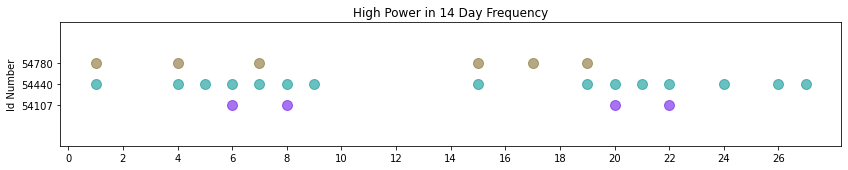

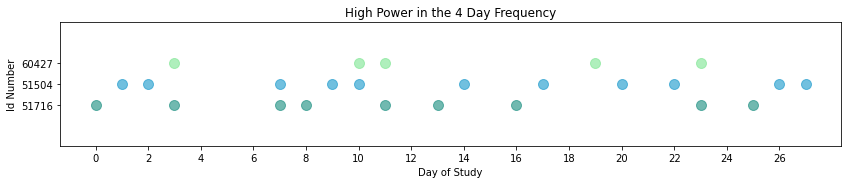

In [10]:
plt.rcParams["figure.figsize"] = [14, 5]

plt.subplot(2,1,1)
low_freq = np.where(processed_data["drink.morning.ft"][:, 2] > .25)[0][:3]
idnum = 0
for i in low_freq:
    drinks = processed_data["drink.morning"][i, :]
    times = np.where(drinks == 1)[0]
    plt.scatter(times, idnum*np.ones(len(times)), s=100, alpha=0.6, c=np.random.rand(1,3))
    idnum += 1

plt.ylim(-2,4)
plt.yticks([0, 1, 2], [processed_data["id"][int(idx)] for idx in low_freq])
plt.ylabel("Id Number")
plt.title("High Power in 14 Day Frequency")
plt.xticks(np.arange(0,28,2))
plt.show()

plt.subplot(2,1,2)
high_freq = np.where(processed_data["drink.morning.ft"][:, 7] > .25)[0]
idnum = 0
for i in high_freq:
    drinks = processed_data["drink.morning"][i, :]
    times = np.where(drinks == 1)[0]
    plt.scatter(times, idnum*np.ones(len(times)), s=100, alpha=0.6, c=np.random.rand(1,3))
    idnum += 1

plt.ylim(-2,4)
plt.yticks([0, 1, 2], [processed_data["id"][int(idx)] for idx in high_freq])
plt.ylabel("Id Number")
plt.title("High Power in the 4 Day Frequency")
plt.xlabel("Day of Study")
plt.xticks(np.arange(0,28,2))

plt.show()

Notes:
1. Permute the days and see changes in the distribution of individuals 
2. Change everyone's days in a different way
3. Compare high drinkers to low drinkers (how their fourier distribution changes)

Short time series
1. The fourier transform is exact
2. Generate random sequences with bernoulli random variables
3. Array with the first two collumns one, permute every row and look at the bins in the fourier transform
4. Random matrix with every person drinking 1/7 of the time vs 1/4 vs 1/2


## Permutation testing of drinking frequency distributions

In [11]:
# This code takes several hour to run. It is commented out so it isn't run on accident

# # Number of times to permute the entire dataset
# N = 10000
# # Make a copy of the morning drinking time series
# D = copy.deepcopy(processed_data['drink.morning'])
# permYf = tuple()
# for k in range(N):
#     # For each individual
#     for ts in D:
#         x = np.arange(28)
#         # Permute their drinkine time series randomly
#         perm = np.random.permutation(ts)
#         # Take the transform
#         xf, yf = fourier_transform(x, perm)
#         # Save for later
#         permYf += (yf,)
# permYf = np.vstack(permYf)
# np.savez("/Users/djpassey/Data/Muri/permuted_data_null.npz", permYf)

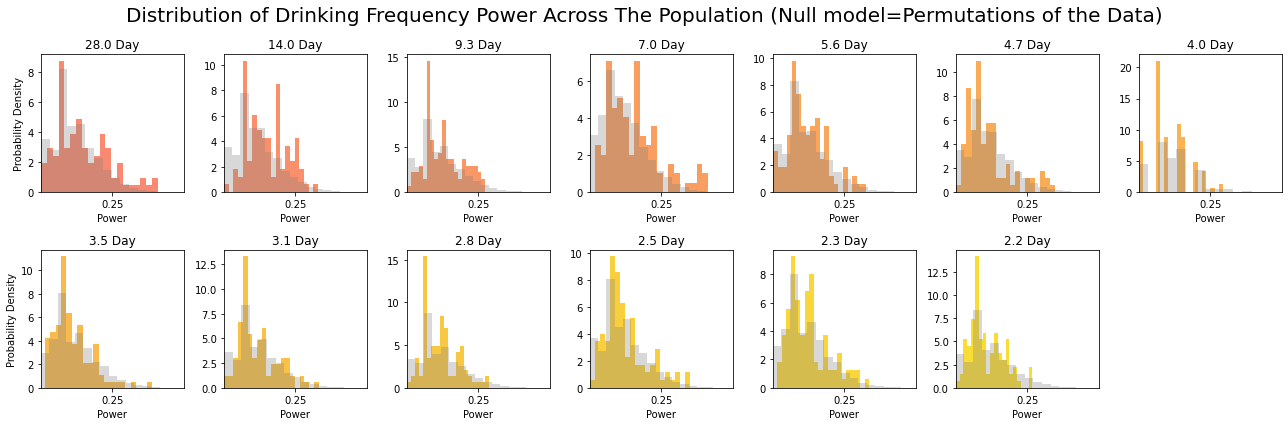

In [12]:
plt.rcParams["figure.figsize"] = [18, 6]

# Load saved Null
permYf = np.load("/Users/djpassey/Data/Muri/permuted_data_null.npz")["arr_0"]

# Frequency axis (For fourier transform)
total_time = 28.0
N = 28
xf = np.arange(N)/ (total_time)
xf = xf[:N//2]

salmon = np.array([250,131,117]) / 256
# Lets do a gradient 
color_grad_step = np.array([0, 7, -5]) / 256
drinker_idx = np.where(np.mean(processed_data["drink.morning"], axis=1) != 0)[0]
drinkers = processed_data["drink.morning.ft"][drinker_idx, :]
cols = drinkers.shape[1]

for j in range(1, cols):
    plt.subplot(2,7,j)
    freq_dist = drinkers[:, j]
    null_dist = permYf[:, j]
    plt.hist(freq_dist, color=salmon + j*color_grad_step, bins=20, density=True)
    plt.hist(null_dist, bins=20, color="grey", alpha=.3, density=True)

    plt.xlim(0,.5)
    #plt.ylim(0, 1)
    plt.xticks([0.25])
    #plt.yticks([0, .5])
    plt.title(f"{round(1/xf[j],1)} Day")
    if j % 7 == 1:
        plt.ylabel("Probability Density")
    plt.xlabel("Power")
    
plt.suptitle("Distribution of Drinking Frequency Power Across The Population (Null model=Permutations of the Data)", fontsize=20)
plt.tight_layout()
plt.show()

## Histogram of Mood Fourier Transform

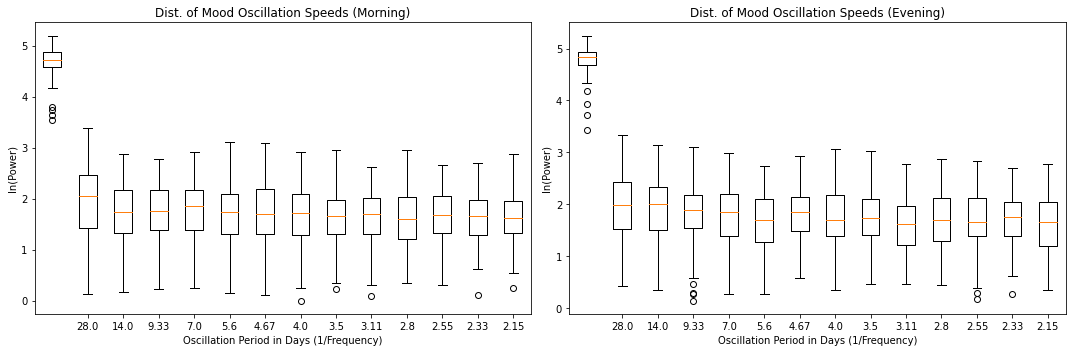

In [13]:
plt.rcParams["figure.figsize"] = [15, 5]

# Frequency axis (For fourier transform)
total_time = 28.0
N = 28
xf = np.arange(N)/ (total_time)
xf = xf[:N//2]

plt.subplot(1, 2, 1) # Fourier transform morning
plt.boxplot(np.log(processed_data["mood.morning.ft"] + 1))
plt.xticks(np.arange(2,15), np.round(1/xf[1:],2))
plt.xlabel("Oscillation Period in Days (1/Frequency)")
plt.title("Dist. of Mood Oscillation Speeds (Morning)")
plt.ylabel("ln(Power)")
#plt.ylim(-.1, 2.50)

plt.subplot(1, 2, 2) # Fourier transform evening
plt.boxplot(np.log(processed_data["mood.evening.ft"] + 1))
plt.xticks(np.arange(2,15), np.round(1/xf[1:],2))
plt.xlabel("Oscillation Period in Days (1/Frequency)")
plt.title("Dist. of Mood Oscillation Speeds (Evening)")
plt.ylabel("ln(Power)")
#plt.ylim(-.1, 2.50)

plt.tight_layout()
plt.show()

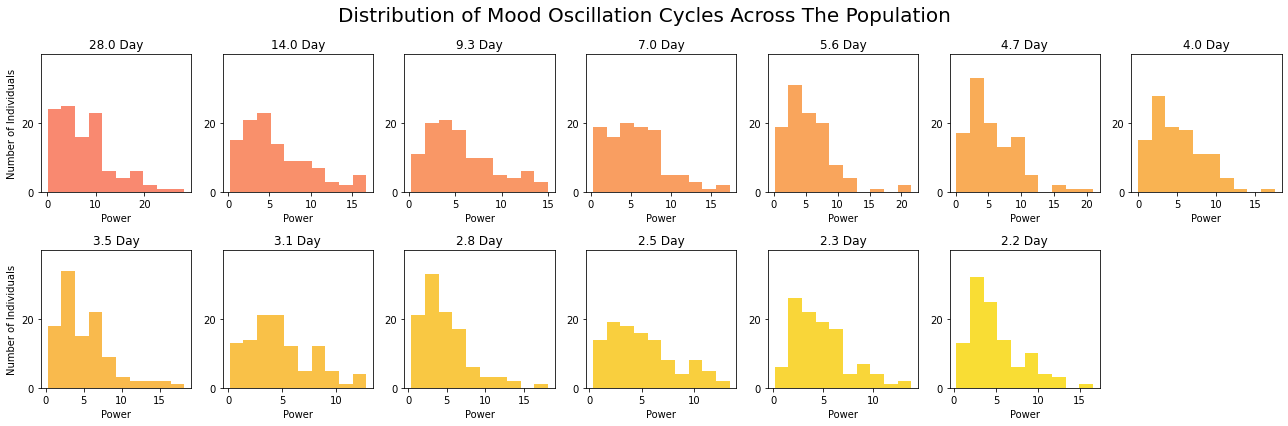

In [14]:
plt.rcParams["figure.figsize"] = [18, 6]

salmon = np.array([250,131,117]) / 256
color_grad_step = np.array([0, 7, -5]) / 256

cols = processed_data["mood.morning.ft"].shape[1]

for j in range(1, cols):
    plt.subplot(2,7,j)
    freq_dist = processed_data["mood.morning.ft"][:, j]
    plt.hist(freq_dist, color=salmon + j*color_grad_step)
    #plt.xlim(0,.5)
    plt.ylim(0, 40)
    #plt.xticks([])
    plt.yticks([0, 20])
    plt.title(f"{round(1/xf[j],1)} Day")
    if j % 7 == 1:
        plt.ylabel("Number of Individuals")
    plt.xlabel("Power")
    
plt.suptitle("Distribution of Mood Oscillation Cycles Across The Population", fontsize=20)
plt.tight_layout()
plt.show()

## Permutation Testing of Mood Fourier Transform

In [15]:
# # This code takes several hour to run. It is commented out so it isn't run on accident

# # Number of times to permute the entire dataset
# N = 10000
# # Make a copy of the morning mood time series
# M = copy.deepcopy(processed_data['mood.morning'])
# permMf = tuple()
# for k in range(N):
#     # For each individual
#     for ts in M:
#         x = np.arange(28)
#         # Permute their drinkine time series randomly
#         perm = np.random.permutation(ts)
#         # Take the transform
#         xf, mf = fourier_transform(x, perm)
#         # Save for later
#         permMf += (mf,)
# permMf = np.vstack(permMf)
# np.savez("/Users/djpassey/Data/Muri/permuted_data_null_mood.npz", permMf)

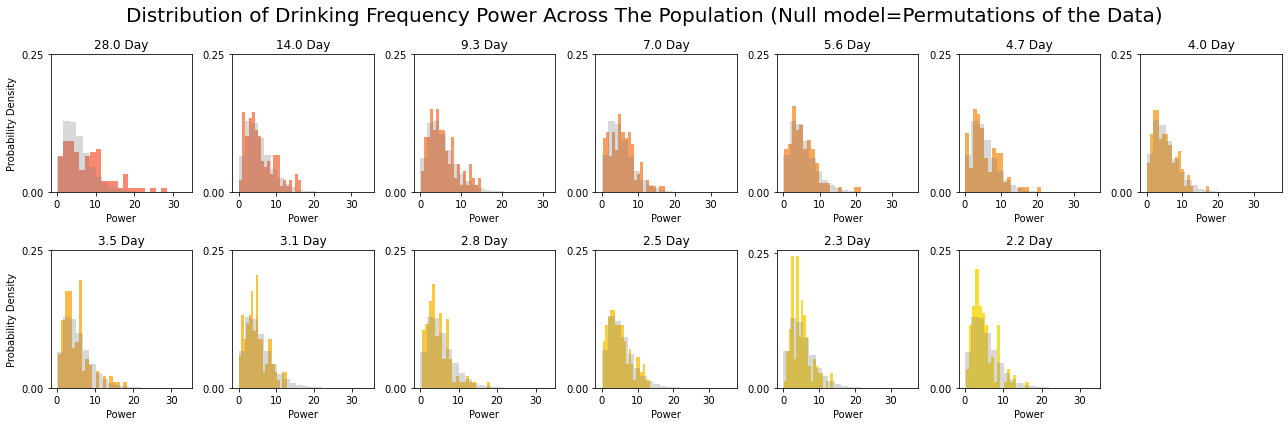

In [16]:
plt.rcParams["figure.figsize"] = [18, 6]

# Load saved Null
permMf = np.load("/Users/djpassey/Data/Muri/permuted_data_null_mood.npz")["arr_0"]

# Frequency axis (For fourier transform)
total_time = 28.0
N = 28
xf = np.arange(N)/ (total_time)
xf = xf[:N//2]

salmon = np.array([250,131,117]) / 256
# Lets do a gradient 
color_grad_step = np.array([0, 7, -5]) / 256

cols = processed_data["mood.morning.ft"].shape[1]

for j in range(1, cols):
    plt.subplot(2,7,j)
    freq_dist = processed_data["mood.morning.ft"][:, j]
    null_dist = permMf[:, j]
    plt.hist(freq_dist, color=salmon + j*color_grad_step, bins=20, density=True)
    plt.hist(null_dist, bins=20, color="grey", alpha=.3, density=True)

    #plt.xlim(0,.5)
    #plt.ylim(0, 1)
    #plt.xticks([0.25])
    plt.yticks([0, .25])
    plt.title(f"{round(1/xf[j],1)} Day")
    if j % 7 == 1:
        plt.ylabel("Probability Density")
    plt.xlabel("Power")
    
plt.suptitle("Distribution of Drinking Frequency Power Across The Population (Null model=Permutations of the Data)", fontsize=20)
plt.tight_layout()
plt.show()

Notes:
1. Use this a tool to measure flexibility
2. Frequency bands like in neuroscience. Are there "healty" bands?
3. Can we compare healthy to unhealthy drinking frequencies?

In [17]:
with np.errstate(divide='ignore'):
    for key in time_series_keys:
        ts = processed_data[key]
        pvals = [adfuller(x)[1] for x in ts]
        processed_data[key + ".adfuller"] = np.array(pvals)

Notes: 
1. Remove higher frequencies and see what happens to the cross-correlations
3. Mood is not lagged, drinking is lagged

# Stationarity of Drinking

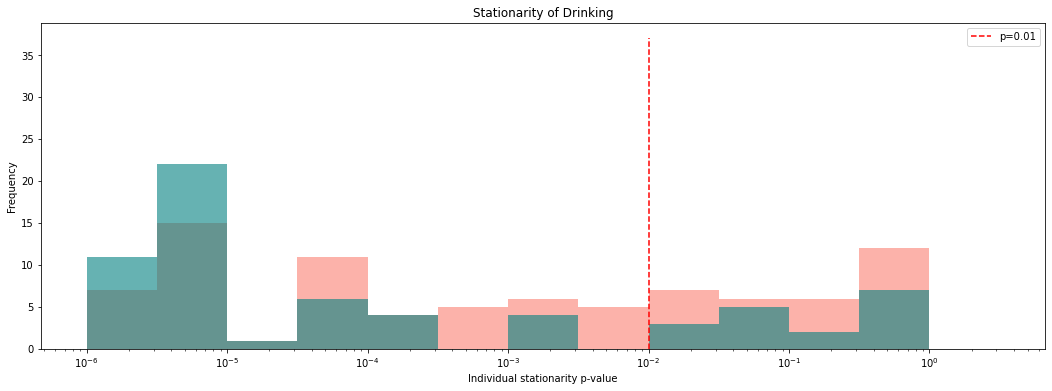

69 / 108 Participants show stationarity in drinking (Morning)
63 / 108 Participants show stationarity in drinking (Evening)


In [18]:

bins = 10**(np.arange(-6.0, 1, 0.5))
dmp = processed_data["drink.morning.adfuller"]
dep = processed_data["drink.evening.adfuller"]
plt.xscale('log')
plt.hist(dmp, bins=bins, color=COLORS[0], alpha=0.6)
plt.hist(dep, bins=bins, color=COLORS[1], alpha=0.6)
plt.plot(np.ones(38)*PVAL, np.arange(0,38), "--", c="r", label=f"p={PVAL}")
plt.xlabel("Individual stationarity p-value")
plt.ylabel("Frequency")
plt.title("Stationarity of Drinking")
plt.legend()
plt.show()

adf_sig = lambda x: np.sum(x < PVAL)
print(f"{adf_sig(dmp)} / 108 Participants show stationarity in drinking (Morning)")
print(f"{adf_sig(dep)} / 108 Participants show stationarity in drinking (Evening)")

# Stationarity of Mood

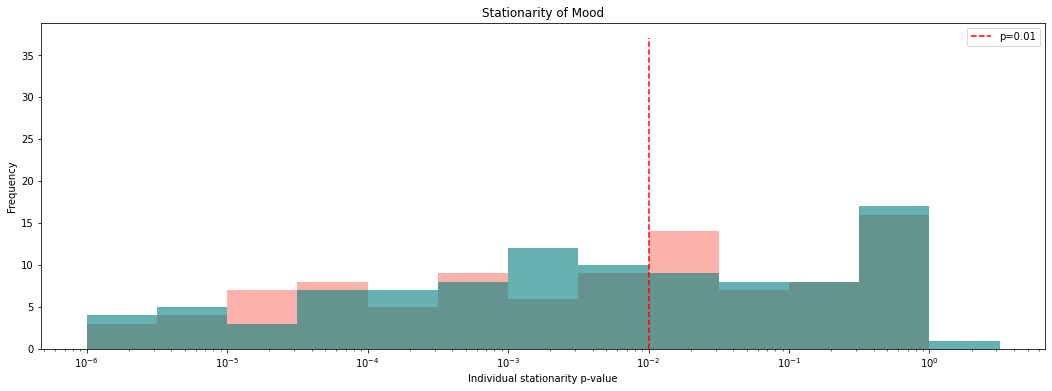

63 / 108 Participants show stationarity in mood (Morning)
65 / 108 Participants show stationarity in mood (Evening)


In [19]:
bins = 10**(np.arange(-6.0, 1, 0.5))
mmp = processed_data["mood.morning.adfuller"]
mep = processed_data["mood.evening.adfuller"]

plt.xscale('log')
plt.hist(mmp, bins=bins, color=COLORS[0], alpha=0.6)
plt.hist(mep, bins=bins, color=COLORS[1], alpha=0.6)
plt.title("Stationarity of Mood")
plt.xlabel("Individual stationarity p-value")
plt.ylabel("Frequency")
plt.plot(np.ones(38)*PVAL, np.arange(0,38), "--", c="r", label=f"p={PVAL}")
plt.legend()
plt.show()

print(f"{adf_sig(mmp)} / 108 Participants show stationarity in mood (Morning)")
print(f"{adf_sig(mep)} / 108 Participants show stationarity in mood (Evening)")

How many were stationary in mood, drinking, both, just one or the other? (In a table)

In [20]:
pval = 0.01
# Remove non drinkers
drink_station = processed_data["drink.morning.adfuller"][drinker_idx]
mood_station = processed_data["mood.morning.adfuller"][drinker_idx]

sta_mood_sta_drink = sum((drink_station < pval) * (mood_station < pval) )
sta_mood_not_drink = sum((drink_station > pval) * (mood_station < pval) )
not_mood_sta_drink = sum((drink_station < pval) * (mood_station > pval) )
not_mood_not_drink = sum((drink_station > pval) * (mood_station > pval) )

stationarity_table = f"""#### Morning Mood and Drinking Stationarity

|  | Stationary Drinking | Non-Stationary Drinking | Totals |
| --- | --- | --- | --- |
| **Stationary Mood**|{sta_mood_sta_drink} |{sta_mood_not_drink} | {sta_mood_sta_drink + sta_mood_not_drink}
| **Non Stationary Mood**| {not_mood_sta_drink}| {not_mood_not_drink}| {not_mood_sta_drink + not_mood_not_drink}
| **Totals**| {sta_mood_sta_drink + not_mood_sta_drink}| {sta_mood_not_drink + not_mood_not_drink} | {sta_mood_sta_drink + sta_mood_not_drink + not_mood_sta_drink + not_mood_not_drink}

"""
md(stationarity_table)

#### Morning Mood and Drinking Stationarity

|  | Stationary Drinking | Non-Stationary Drinking | Totals |
| --- | --- | --- | --- |
| **Stationary Mood**|37 |19 | 56
| **Non Stationary Mood**| 32| 12| 44
| **Totals**| 69| 31 | 100



This table displays a grouping of individuals by mood and drinking stationarity. Stationarity is a property of a time series indicating if the series is flat, i.e. does not contain increasing or decreasing trends. For this dataset, we apply a statistical test to determine if an individuals drinking or mood time series are flat over the course of the study. 

We group 100 of the 109 participants into four groups in the table above (one excluded for incomplete data, 8 excluded for not drinking), indicating the number of individuals with each combination of stationarity and non-stationarity. We use a p-value of 0.01 as our cutoff. An additional table below shows the same result for a p-value of 0.1.



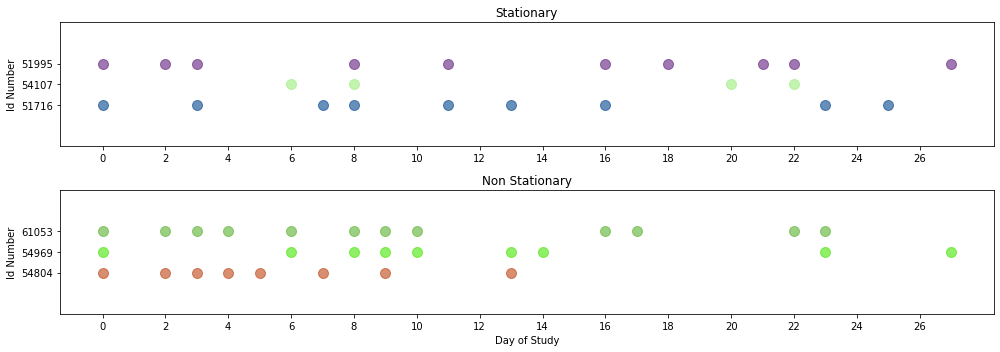

In [21]:
plt.rcParams["figure.figsize"] = [14, 5]

plt.subplot(2,1,1)
station = np.where(processed_data["drink.morning.adfuller"] < 1e-6)[0][:3]
idnum = 0
for i in station:
    drinks = processed_data["drink.morning"][i, :]
    times = np.where(drinks == 1)[0]
    plt.scatter(times, idnum*np.ones(len(times)), s=100, alpha=0.6, c=np.random.rand(1,3))
    idnum += 1

plt.ylim(-2,4)
plt.yticks([0, 1, 2], [processed_data["id"][int(idx)] for idx in station])
plt.ylabel("Id Number")
plt.title("Stationary")
plt.xticks(np.arange(0,28,2))

plt.subplot(2,1,2)
non_station = np.where(processed_data["drink.morning.adfuller"] > .4)[0][:3]
idnum = 0
for i in non_station:
    drinks = processed_data["drink.morning"][i, :]
    times = np.where(drinks == 1)[0]
    plt.scatter(times, idnum*np.ones(len(times)), s=100, alpha=0.6, c=np.random.rand(1,3))
    idnum += 1

plt.ylim(-2,4)
plt.yticks([0, 1, 2], [processed_data["id"][int(idx)] for idx in non_station])
plt.ylabel("Id Number")
plt.title("Non Stationary")
plt.xticks(np.arange(0,28,2))
plt.xlabel("Day of Study")

plt.tight_layout()
plt.show()

In [22]:
pval = 0.1
# Remove non drinkers
drink_station = processed_data["drink.morning.adfuller"][drinker_idx]
mood_station = processed_data["mood.morning.adfuller"][drinker_idx]

sta_mood_sta_drink = sum((drink_station < pval) * (mood_station < pval) )
sta_mood_not_drink = sum((drink_station > pval) * (mood_station < pval) )
not_mood_sta_drink = sum((drink_station < pval) * (mood_station > pval) )
not_mood_not_drink = sum((drink_station > pval) * (mood_station > pval) )

stationarity_table = f"""#### Morning Mood and Drinking Stationarity

|  | Stationary Drinking | Non-Stationary Drinking | Totals |
| --- | --- | --- | --- |
| **Stationary Mood**|{sta_mood_sta_drink} |{sta_mood_not_drink} | {sta_mood_sta_drink + sta_mood_not_drink}
| **Non Stationary Mood**| {not_mood_sta_drink}| {not_mood_not_drink}| {not_mood_sta_drink + not_mood_not_drink}
| **Totals**| {sta_mood_sta_drink + not_mood_sta_drink}| {sta_mood_not_drink + not_mood_not_drink} | {sta_mood_sta_drink + sta_mood_not_drink + not_mood_sta_drink + not_mood_not_drink}

"""
md(stationarity_table)

#### Morning Mood and Drinking Stationarity

|  | Stationary Drinking | Non-Stationary Drinking | Totals |
| --- | --- | --- | --- |
| **Stationary Mood**|62 |14 | 76
| **Non Stationary Mood**| 20| 4| 24
| **Totals**| 82| 18 | 100



## Fourier Transform of Stationary Drinkers

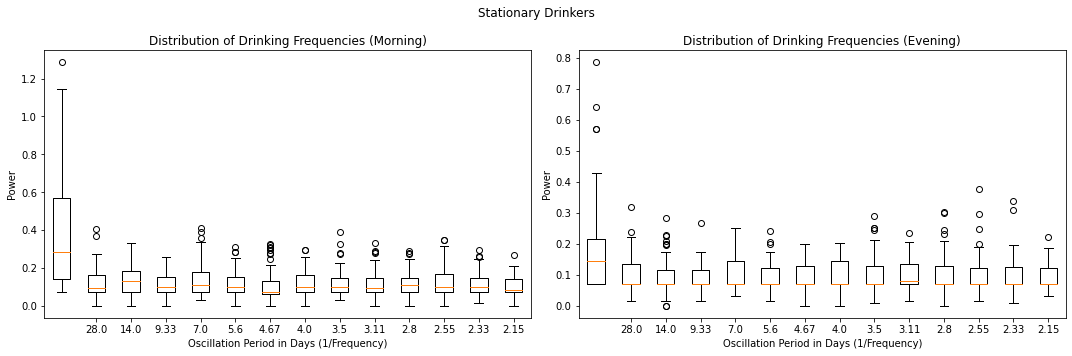

In [23]:
plt.rcParams["figure.figsize"] = [15, 5]

# Frequency axis (For fourier transform)
total_time = 28.0
N = 28
xf = np.arange(N)/ (total_time)
xf = xf[:N//2]
# Exlude non drinkers and nonstationary drinkers
station_morning = (processed_data["drink.morning.adfuller"] < 0.01) * (np.mean(processed_data["drink.morning"], axis=1) != 0)
station_evening = (processed_data["drink.evening.adfuller"] < 0.01) * (np.mean(processed_data["drink.evening"], axis=1) != 0)

plt.subplot(1, 2, 1) # Fourier transform morning
plt.boxplot(processed_data["drink.morning.ft"][station_morning, :])
plt.xticks(np.arange(2,15), np.round(1/xf[1:],2))
plt.xlabel("Oscillation Period in Days (1/Frequency)")
plt.title("Distribution of Drinking Frequencies (Morning)")
plt.ylabel("Power")
#plt.ylim(-.1, 2.50)

plt.subplot(1, 2, 2) # Fourier transform evening
plt.boxplot(processed_data["drink.evening.ft"][station_evening, :])
plt.xticks(np.arange(2,15), np.round(1/xf[1:],2))
plt.title("Distribution of Drinking Frequencies (Evening)")
plt.ylabel("Power")
#plt.ylim(-.1, 2.50)
plt.xlabel("Oscillation Period in Days (1/Frequency)")

plt.suptitle("Stationary Drinkers")
plt.tight_layout()
plt.show()

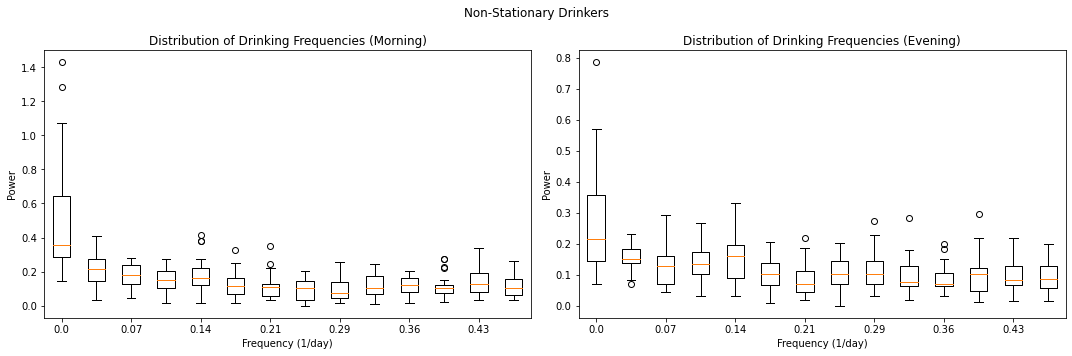

In [24]:
plt.rcParams["figure.figsize"] = [15, 5]

# Frequency axis (For fourier transform)
total_time = 28.0
N = 28
xf = np.arange(N)/ (total_time)
xf = xf[:N//2]
# Exlude non drinkers and nonstationary drinkers
station_morning = (processed_data["drink.morning.adfuller"] > 0.01) * (np.mean(processed_data["drink.morning"], axis=1) != 0)
station_evening = (processed_data["drink.evening.adfuller"] > 0.01) * (np.mean(processed_data["drink.evening"], axis=1) != 0)

plt.subplot(1, 2, 1) # Fourier transform morning
plt.boxplot(processed_data["drink.morning.ft"][station_morning, :])
plt.xticks(np.arange(1,15,2), np.round(xf[::2],2))
plt.title("Distribution of Drinking Frequencies (Morning)")
plt.ylabel("Power")
#plt.ylim(-.1, 2.50)
plt.xlabel("Frequency (1/day)")

plt.subplot(1, 2, 2) # Fourier transform evening
plt.boxplot(processed_data["drink.evening.ft"][station_evening, :])
plt.xticks(np.arange(1,15,2), np.round(xf[::2],2))
plt.title("Distribution of Drinking Frequencies (Evening)")
plt.ylabel("Power")
#plt.ylim(-.1, 2.50)
plt.xlabel("Frequency (1/day)")

plt.suptitle("Non-Stationary Drinkers")

plt.tight_layout()
plt.show()

Are there enough to draw conclusions? ($n=20$)

# Autocorrelation of Drinking

In [25]:
def ccf(x, y, lag_max = 100, return_lags=False):
    """ Python version of R ccf function """

    result = signal.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)
    if return_lags:
        return np.arange(lo, hi), result[lo:hi]
    return result[lo:hi]

def ccf_lags(x, y, ccf_output):
    """ Lags corresponding to output of ccf """
    
    
    
def autocorr(x):
    return ccf(x, x)

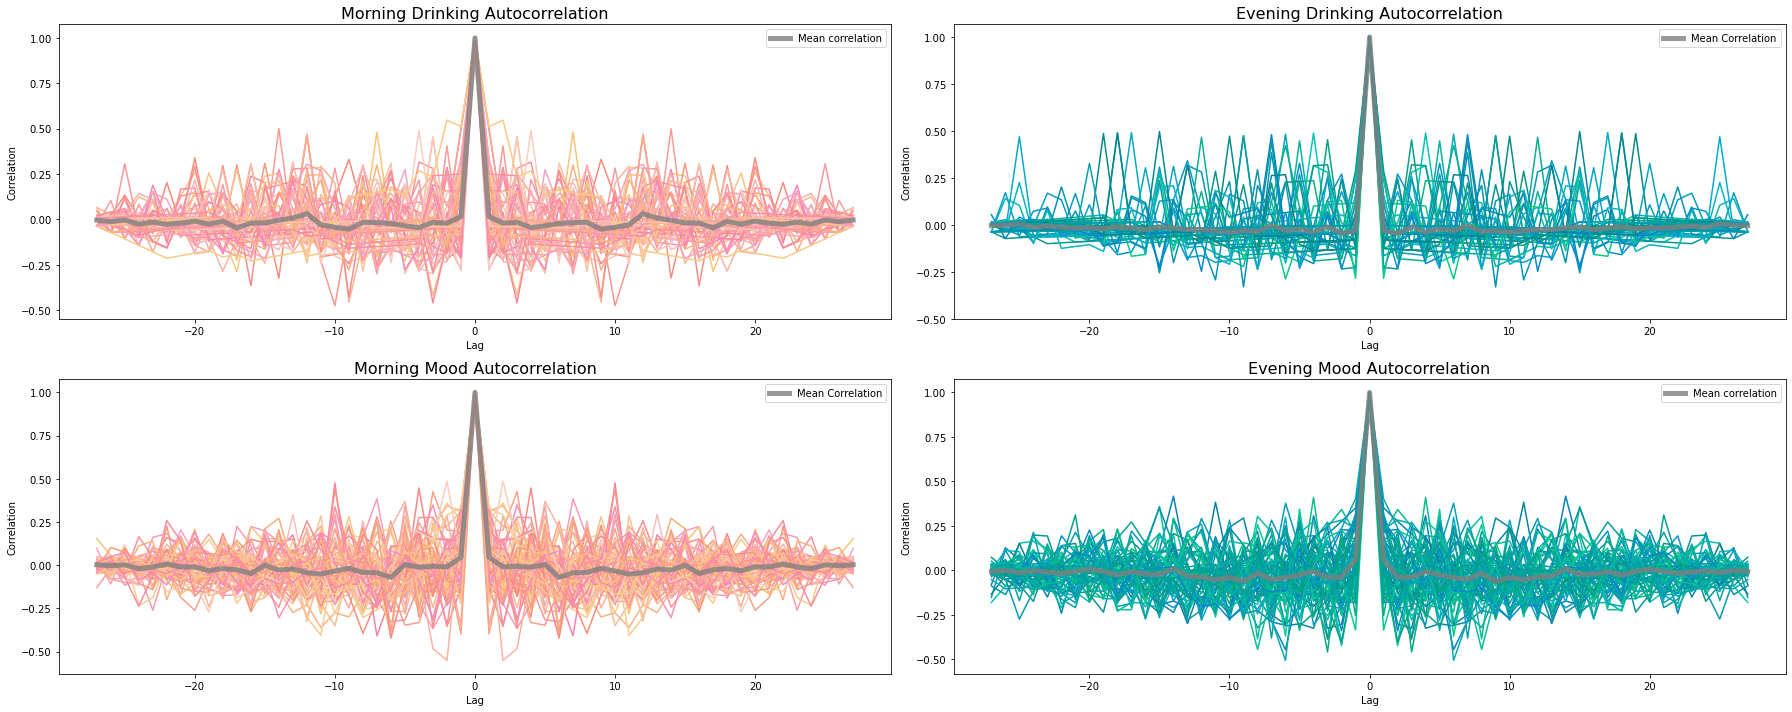

In [26]:
plt.rcParams["figure.figsize"] = [25, 10]
lags = np.arange(-27, 28)

plt.subplot(2,2,1)
mu_mm_ac = np.zeros(55)
n = 0
salmon = np.array([250,131,117]) / 256
for x, p in zip(processed_data["drink.morning"], processed_data["drink.morning.adfuller"]):
    
    if p < 0.01:
        ac = autocorr(x)
        mu_mm_ac += ac
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, ac, c=salmon + jitter)
        
plt.plot(lags, mu_mm_ac/n, lw=5, alpha=0.8, c="gray", label="Mean correlation")
plt.title("Morning Drinking Autocorrelation", fontsize=16)
plt.xlabel("Lag")
plt.yticks([-.5, -.25, 0., .25, .5, .75, 1])
plt.ylabel("Correlation")
plt.legend()

plt.subplot(2,2,2)
mu_em_ac = np.zeros(55)
n = 0
teal = np.array([4,128,128]) / 256
for x, p in zip(processed_data["drink.evening"], processed_data["drink.evening.adfuller"]):
    
    if p < 0.01:
        ac = autocorr(x)
        mu_em_ac += ac
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, ac, c=teal + jitter)
plt.plot(lags, mu_em_ac/n, lw=5, alpha=0.8, c="gray", label="Mean Correlation")
plt.title("Evening Drinking Autocorrelation", fontsize=16)
plt.xlabel("Lag")
plt.yticks([-.5, -.25, 0., .25, .5, .75, 1])
plt.ylabel("Correlation")
plt.legend()

plt.subplot(2,2,3)
mu_mm_ac = np.zeros(55)
n = 0
salmon = np.array([250,131,117]) / 256
for x, p in zip(processed_data["mood.morning"], processed_data["mood.morning.adfuller"]):
    
    if p < 0.01:
        ac = autocorr(x)
        mu_mm_ac += ac
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, ac, c=salmon + jitter)
plt.plot(lags, mu_mm_ac/n, lw=5, alpha=0.8, c="gray", label="Mean Correlation")
plt.title("Morning Mood Autocorrelation", fontsize=16)
plt.xlabel("Lag")
plt.yticks([-.5, -.25, 0., .25, .5, .75, 1])
plt.ylabel("Correlation")
plt.legend()

plt.subplot(2,2,4)
mu_em_ac = np.zeros(55)
n = 0
teal = np.array([4,128,128]) / 256
for x, p in zip(processed_data["mood.evening"], processed_data["mood.evening.adfuller"]):
    
    if p < 0.01:
        ac = autocorr(x)
        mu_em_ac += ac
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, ac, c=teal + jitter)
plt.plot(lags, mu_em_ac/n, lw=5, alpha=0.8, c="gray", label="Mean correlation")
plt.title("Evening Mood Autocorrelation", fontsize=16)
plt.xlabel("Lag")
plt.yticks([-.5, -.25, 0., .25, .5, .75, 1])
plt.ylabel("Correlation")
plt.legend()

plt.tight_layout()
plt.show()

## Cross Correlation of Mood and Drinking

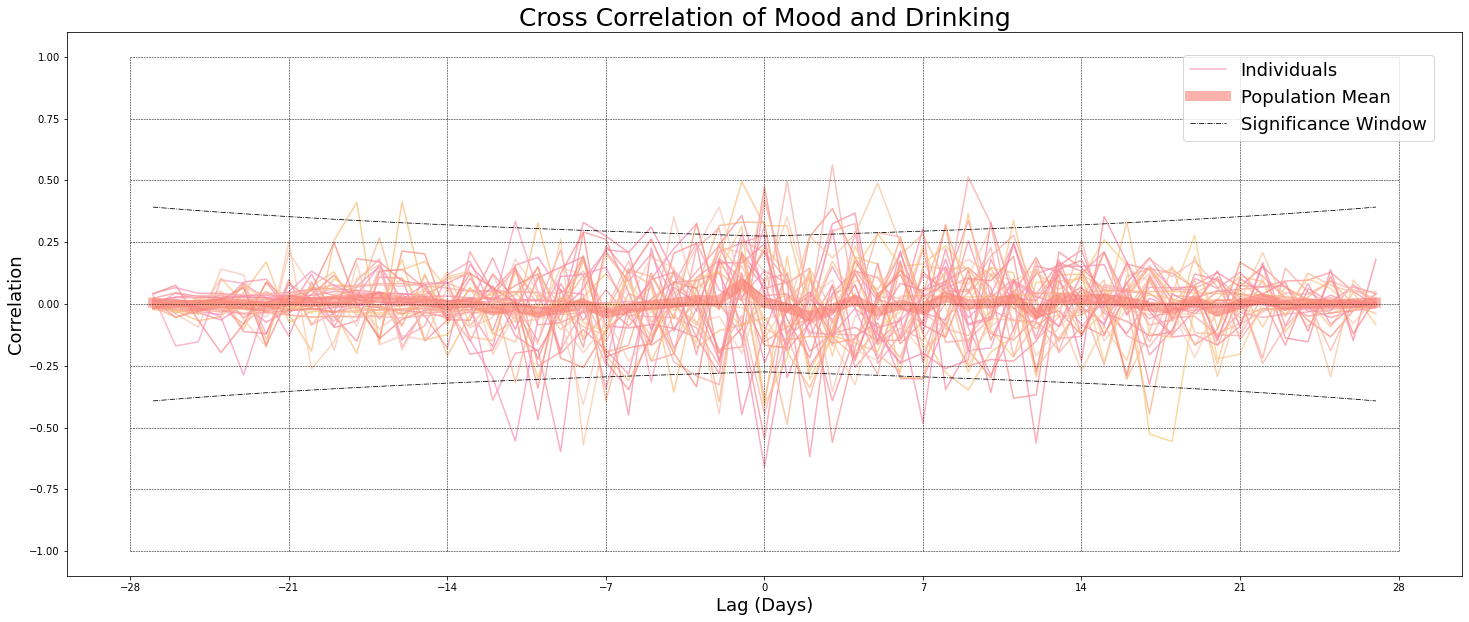

In [27]:
mu_cc = np.zeros(55)
n = 0

for m, mp, d, dp in zip(processed_data["mood.morning"], processed_data["mood.morning.adfuller"], processed_data["drink.morning"], processed_data["drink.morning.adfuller"]):
    if (mp < 0.01) and (dp < 0.01):
        cc = ccf(d, m)
        mu_cc += cc
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, cc, c=salmon + jitter, alpha=0.7)
# Extra point to add a label to the legend
plt.plot(lags[0], cc[0], c=salmon + jitter, alpha=0.7, label="Individuals")
# Population mean
plt.plot(lags, mu_cc/n, lw=10, alpha=0.6, c="salmon", label="Population Mean")
# Significance curve
plt.plot(lags , 2/(53 - np.abs(lags))**.5, "-.", c="k", lw=0.8, label="Significance Window")
plt.plot(lags , -2/(53 - np.abs(lags))**.5, "-.", c="k", lw=0.8)


xtick_locs = np.arange(-28, 29, 7)
# Grid lines
for y in np.arange(-1, 1.25, 0.25):
    plt.plot(xtick_locs, y*np.ones_like(xtick_locs), "--", c="k", lw=0.5)
for x in xtick_locs:
    plt.plot(x*np.ones_like(lags), np.linspace(-1, 1, len(lags)), "--", c="k", lw=0.5)
    
plt.title("Cross Correlation of Mood and Drinking", fontsize=25)
plt.xlabel("Lag (Days)", fontsize=18)
plt.ylabel("Correlation", fontsize=18)
plt.xticks(xtick_locs)
plt.legend(loc=(0.8, 0.8), fontsize=18)
plt.show()

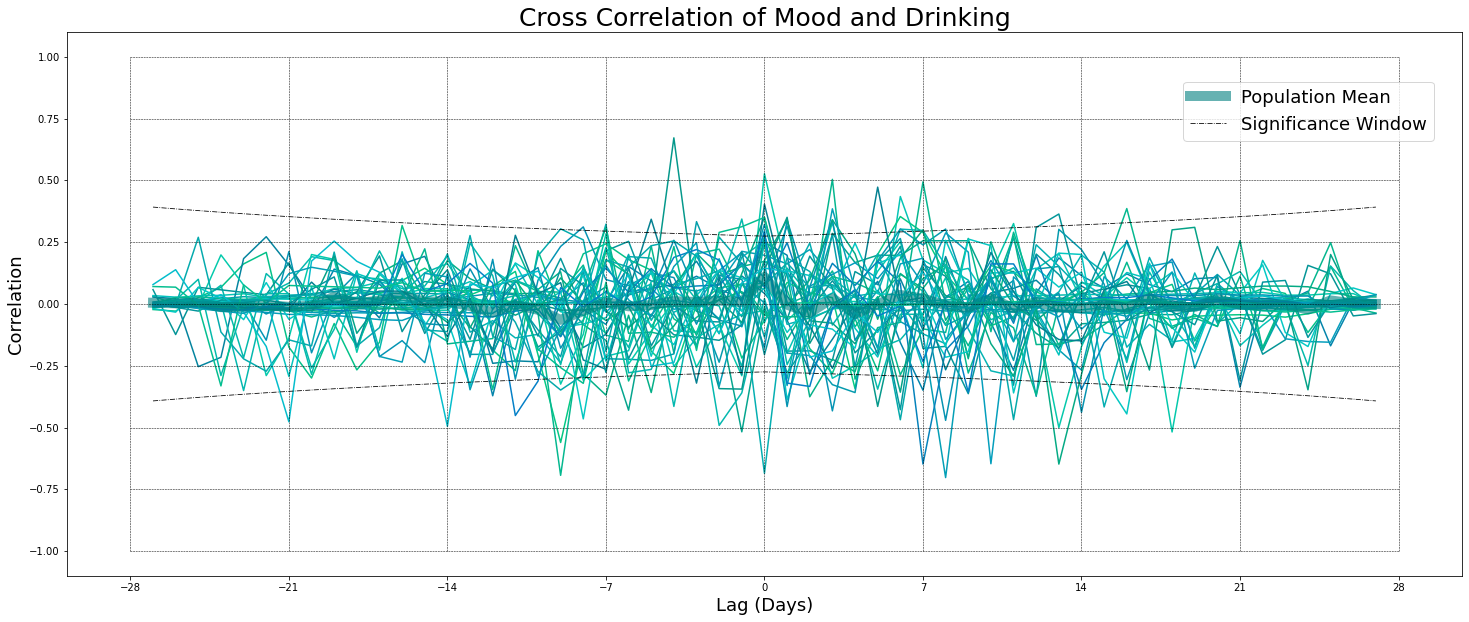

In [28]:
mu_cc = np.zeros(55)
n = 0

for m, mp, d, dp in zip(processed_data["mood.evening"], processed_data["mood.evening.adfuller"], processed_data["drink.evening"], processed_data["drink.evening.adfuller"]):
    
    if (mp < 0.01) and (dp < 0.01):
        cc = ccf(m, d)
        mu_cc += cc
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, cc, c=teal + jitter)
plt.plot(lags, mu_cc/n, lw=10, alpha=0.6, c="teal", label="Population Mean")

# Significance curve
plt.plot(lags , 2/(53 - np.abs(lags))**.5, "-.", c="k", lw=0.8, label="Significance Window")
plt.plot(lags , -2/(53 - np.abs(lags))**.5, "-.", c="k", lw=0.8)


xtick_locs = np.arange(-28, 29, 7)
# Grid lines
for y in np.arange(-1, 1.25, 0.25):
    plt.plot(xtick_locs, y*np.ones_like(xtick_locs), "--", c="k", lw=0.5)
for x in xtick_locs:
    plt.plot(x*np.ones_like(lags), np.linspace(-1, 1, len(lags)), "--", c="k", lw=0.5)
    
plt.title("Cross Correlation of Mood and Drinking", fontsize=25)
plt.xlabel("Lag (Days)", fontsize=18)
plt.ylabel("Correlation", fontsize=18)
plt.xticks(xtick_locs)
plt.legend(loc=(0.8, 0.8), fontsize=18)
plt.show()